# Progetto MOBD 2020-2021
## Authors: Lorenzo Rossi, Andrea Efficace
## Project: MOBD
## Description: Script per la generazione del migliora classificatore secondo la metrica di valutazione "F1-score"

In [1]:
# Package base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pickle
#Splitting dati
import sklearn.model_selection as model_select
#Scoring
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
# Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import (RobustScaler, PolynomialFeatures)
from sklearn.cluster import DBSCAN, OPTICS
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC, LinearSVC
#Cross Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [2]:
"""Importing data from .cvs file

    Returns:

        read_csv(str): array containing dataset
"""
dataset = pd.read_csv('training_set.csv')
dataset


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F15,F16,F17,F18,F19,F20,F21,F22,F23,Label
0,NaN,1.357735,-0.645232,-1.524176,NaN,-1.524176,-1.220206,0.606146,NaN,-0.164011,...,0.932352,-1.934777,0.537243,1.053543,5.757696,-0.703544,-2.240894,-0.684588,0.272049,1.0
1,-0.187455,-0.841512,-0.158584,-3.227462,0.172425,-3.227462,1.411919,NaN,0.615673,-2.071475,...,-0.415631,-6.031057,NaN,3.321213,2.092218,1.869167,0.473742,1.466099,-0.118461,3.0
2,NaN,1.091768,0.440716,-1.613265,0.055077,-1.613265,-4.278591,1.618829,-0.730272,-3.829564,...,-0.534465,NaN,-1.471547,1.306540,3.886876,-0.195097,-0.456806,1.616122,-0.764173,1.0
3,-1.394021,1.590641,0.246730,4.965631,0.150593,4.965631,1.482024,2.224675,1.973746,2.656690,...,0.334828,0.117789,-1.901424,-1.102605,2.783440,-1.216669,-2.725353,-1.620713,-0.628058,0.0
4,0.606877,0.625310,-0.513682,2.623703,NaN,2.623703,2.335449,0.078711,-0.581077,0.655329,...,-1.217484,-5.670036,0.612314,-0.546315,0.063950,1.689753,-0.359699,1.610013,0.054129,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.192594,-0.453595,-0.057883,0.407408,-1.365127,0.407408,-0.405437,-1.506944,-0.783212,0.230677,...,-1.075146,4.529417,2.470978,-0.309338,3.441702,-2.415452,-1.421139,-0.574091,-0.565556,0.0
9996,-0.932227,-1.214498,0.942853,-0.906137,0.507329,-0.906137,2.412041,0.757290,-2.169308,-2.320857,...,0.753918,-2.704671,-1.865146,0.425525,-6.214690,-2.665123,-0.562713,1.810629,-0.847753,2.0
9997,0.246281,1.025481,2.380364,-3.685697,-0.878248,-3.685697,0.924516,1.803711,0.567494,-2.029683,...,0.985395,-4.006701,-5.685372,-1.129747,-2.564002,2.514938,-0.830348,1.686868,1.909690,2.0
9998,-1.252158,-0.974074,0.556018,2.035217,NaN,2.035217,-0.074624,-4.591799,1.761420,-1.188773,...,1.039871,7.894771,1.944460,-6.047688,-2.121010,1.485629,-0.667930,-0.645083,-1.085183,2.0


## Idetificazione del dataset

In [3]:
"""Preprocessing Data:
    -Identify output label;
    -Identify features list;
    -Extract output values;
    -Obtain features names;
"""
target = 'Label'
x = dataset.drop(target, axis=1)
y = dataset[target]
features_list = x.columns.values.tolist()

## CLassi di supporto

### Classe di Preprocessamento
#### Questa classe ha il compito di effettuare il preprocessamento dei dati. In particolare.
#### Input:
#####        -eps (DBSCAN)[int]: distanza euclidea utilizzata per rilevare il rumore nel dataset tramite clustering;
#####        -min_samples (DBSCAN)[int]: numero minimo di punti utilizzati per definire un cluster;
#####        -n_neighbors (KNNImputer)[int]: numero di vicini per utilizzati per rimpiazzare i valori NaN all'interno del Training_set (train_x).
#####        - Si utilizza IQR (calcolro degli interquartili) per rimpiazzare gli outliers
###### N.B.: al fine di permettere la modifica dei punti all'interno di un Pipeline, consentendo anche la riduzione del loro numero, si utilizza la classe BaseEstimator. Inoltre, deve implementare i metodi fit() e fit_resample()

In [4]:
class Preprocessing(BaseEstimator):

    def __init__(self, epsilon=6.5, min_samples=10, n_neighbors=2):
        self.epsilon = epsilon
        self.min_samples = min_samples
        self.scanner = DBSCAN(eps=self.epsilon, min_samples=self.min_samples, n_jobs=-1)
        self.upper_bound = 0
        self.lower_bound = 0
        self.n_neighbors = n_neighbors
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors, weights='distance')
        
    #Return DB SCAN
    def get_scanner(self):
        return self.scanner
    #Return self.resample(X,y)
    def fit_resample(self, X, y):
        return self.resample(X, y)
    #Return x,y preprocessed
    def resample(self, X, y):
        x = pd.DataFrame(X)
        y = pd.DataFrame(y)
        # Noise removal
        self.scanner.fit(x)
        noise = x[self.scanner.labels_ == -1].index.values
        x = x.drop(index=noise)
        y = y.drop(index=noise)
        # Outlier removal
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound = q1 - (1.5 * iqr)
        self.upper_bound = q3 + (1.5 * iqr)
        x.where(~((x < self.lower_bound) | (x > self.upper_bound)), np.nan, inplace=True)
        x = pd.DataFrame(self.imputer.fit_transform(x))
        y_rv = y.values.ravel()
        return x, y_rv

### Rimpiazzamento dei valori NaN e Split in train_set e validation_set
#### Si utilizza la funzine KNNImputer(n_neigjbors,weights) per rimpiazzare i valori NaN nel dataset per permetterne il preprocessamento 

In [5]:
# Rimpiazzo dei valori NaN
imputer = KNNImputer(n_neighbors=10, weights='distance')
dati_imputati = imputer.fit_transform(x)

# Dataset senza NaN in forma di Dataframe
X_imputer = pd.DataFrame(dati_imputati)
y_df = pd.DataFrame(y)
# Split traingin_set e validation_set
x_train, x_val, y_train, y_val = model_select.train_test_split(X_imputer, y_df,
                                                               test_size=0.2,
                                                               random_state=42,
                                                               stratify=y_df)
print('\nTraining set shape:', x_train.shape, y_train.shape)
print('Test set shape:', x_val.shape, y_val.shape)


Training set shape: (8000, 23) (8000, 1)
Test set shape: (2000, 23) (2000, 1)


### Pipeline
#### La Pipeline permette di eseguire in sequenza gli step di classificazione definiti al suo interno. Ogni funzione utilizzata in Pipeline deve implementare metodi di fit(X,y=None) e transform(X,y=None) ad eccezzione della classe Preprocessing()

In [6]:

pipe_balancedBegging_svm = Pipeline(steps=[
    ('preprocessing', Preprocessing()),
    ('pre_process', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('scaler', None),
    ('feature_selection', SelectFromModel(LinearSVC(C=1.e-3, dual=True, class_weight='balanced', random_state=42))),
    ('classifier',
     BalancedBaggingClassifier(base_estimator=SVC(class_weight='balanced', random_state=42),
                               n_jobs=-1,
                               n_estimators=150,
                               oob_score=True,
                               bootstrap=True))
])



### Definizione dei parametri di Pipeline
#### Definizione dei parametri utilizzati nella Pipeline per effettuare l'operazione di Cross-Validation. Vengono riportati solo i valori che si sono rilevati migliori rispetto alla specifica assegnataci di 80% di best score

In [7]:
imputer_neighbors = [7]
threshold = [0.3]
scaler = [RobustScaler()]
#eps = [6.35]
eps = [3]
#min_sample = [5]
min_sample = [1]
C_values = [1.e-3]
degree = [2]
gamma = [1.0]
kernels = ['poly']
degree_qda = [2]
params_svm_bagging = [{'preprocessing__epsilon': eps,
                       'preprocessing__min_samples': min_sample,
                       'preprocessing__n_neighbors': imputer_neighbors,
                       'pre_process__degree': degree_qda,
                       'scaler': scaler,
                       'classifier__base_estimator__C': C_values,
                       'classifier__base_estimator__degree': degree,
                       'classifier__base_estimator__gamma': gamma,
                       'classifier__base_estimator__kernel': kernels
                       }]

### Cross-Validation
#### Abbiamo scelto di utilizzare StratifiedKFold(n_split). StratifiedKFold è una variazione di k-fold, ma con la differenza che ritorna dei fold stratificati con la particolarita che ogni insieme contiente approssimatamente la stessa percentuale di campioni di ogni classe target.
#### GridSearchCV permette di effettuare il "tuning" degli iperparametri dello stimatore. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'classifier__base_estimator__C': 0.001, 'classifier__base_estimator__degree': 2, 'classifier__base_estimator__gamma': 1.0, 'classifier__base_estimator__kernel': 'poly', 'pre_process__degree': 2, 'preprocessing__epsilon': 3, 'preprocessing__min_samples': 1, 'preprocessing__n_neighbors': 7, 'scaler': RobustScaler()}
0.8385493721501227
Pipeline(steps=[('preprocessing',
                 Preprocessing(epsilon=3, min_samples=1, n_neighbors=7)),
                ('pre_process',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaler', RobustScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=0.001,
                                                     class_weight='balanced',
                                                     random_state=42))),
                ('classifier',
                 BalancedBaggingClassifier(base_estimator=

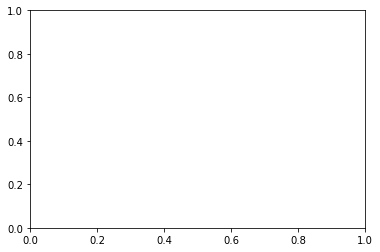

In [8]:
fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits=5)
best_estimator = None
gs = GridSearchCV(estimator=pipe_balancedBegging_svm,
                  param_grid=params_svm_bagging,
                  scoring='f1_macro',
                  cv=cv.split(x_train, y_train),
                  n_jobs=-1,
                  refit=True,
                  verbose=10)

gs.fit(x_train, y_train[target])
print(gs.best_params_)
y_tr_pred = gs.predict(x_train)
best_estimator = gs.best_estimator_
print(gs.best_score_)
print(best_estimator)

### Valutazioni sul Validation Set e sul Test Set

In [9]:
def show_confusion_matrix(cm, f1_score, title):
    """Displays confusion matrix with annotations."""
    # Crea 'assi'.
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = \
        ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    box_labels = \
        [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])
    # Mostra la confusion matrix.
    sns.heatmap(cm,
                annot=box_labels,
                fmt="",
                cmap="YlGnBu",
                cbar=False,
                linewidths=1.0) \
        .set(title=title,
             xlabel='Predicted class\n\nF1 macro: %0.4f' % f1_score,
             ylabel='Actual class')
    plt.show()


In [10]:
def evaluate_classifier(classifier, data_x, data_y, matrix_title='', show=True):
    pred_y = classifier.predict(data_x)
    confusion_matrix = metrics.confusion_matrix(data_y, pred_y)
    f1_score = metrics.f1_score(data_y, pred_y, average='macro')
    if show:
        show_confusion_matrix(confusion_matrix, f1_score, matrix_title)
    return f1_score

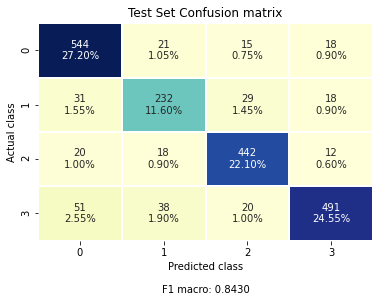


Test set F1 macro: 0.8430


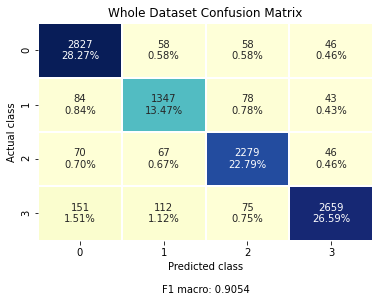


(Post-save) Dataset F1 macro: 0.9054


In [11]:
print('\nTest set F1 macro: %0.4f'
      % evaluate_classifier(best_estimator,
                            x_val,
                            y_val[target],
                            'Test Set Confusion matrix'))

print('\n(Post-save) Dataset F1 macro: %0.4f'
      % evaluate_classifier(best_estimator,
                            X_imputer,
                            y_df[target],
                            'Whole Dataset Confusion Matrix'))

In [12]:
file_bestclassifier = open('bestClassifier.sav','wb')
pickle.dump(best_estimator,file_bestclassifier)
file_bestclassifier.close()

# Plot dell'F1-score

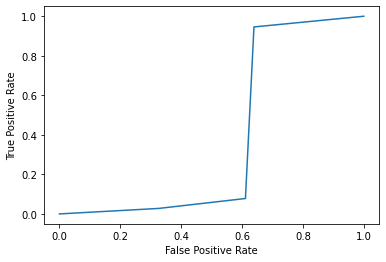

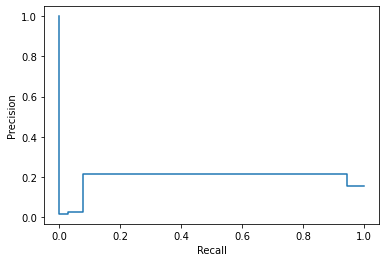

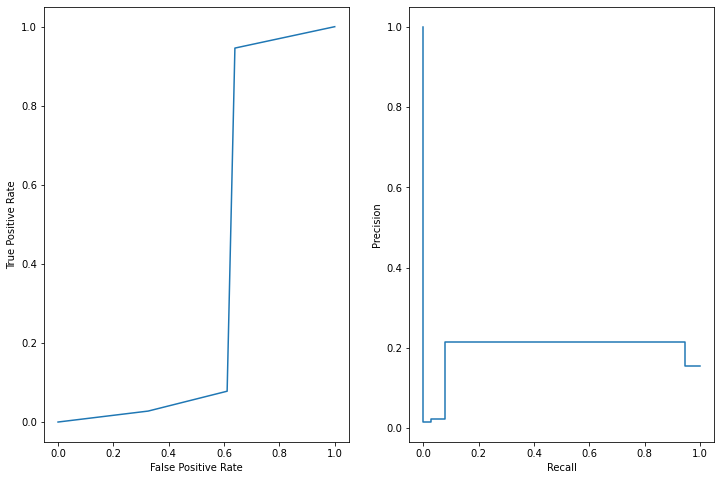

In [13]:

fpr, tpr, _ = roc_curve(y_df[target], best_estimator.predict(X_imputer), pos_label=best_estimator.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
prec, recall, _ = precision_recall_curve(y_df[target], best_estimator.predict(X_imputer),
pos_label=best_estimator.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()